# 1.  Vehicle Loads and Design

In Golden, CO, air density is going to be a bit lower than at sea level, we will hard code it at 1.01 kg•m<sup>-3</sup>.

In [1]:
# constants
G = 9.81  # m/s^2
R_air = 8314.5 / 28.96  # gas constant for air (in J/kg*K)
energydensity_fuel = 34.2  # gasoline energy density (in MJ/l)

# ambient air conditions
ambient = dict(
    v_air=0,  # ambient wind velocity where negative is headwind  (in m/s)
    # temp=25 + 273.15,  # ambient air temperature (in K)
    # pressure=98000,  # ambient air pressure (in Pa)
    rho=1.01,  # hardcoding in air density kg/m^3
)
# ambient["rho"] = ambient["pressure"] / (
#     R_air * ambient["temp"]
# )  # ambient air density (in kg/m^3)

# subaru outback
vehicle = dict(
    mass=1800,  # vehicle mass [kg]
    C_drag=0.37,  # drag coefficient [-]
    A_front=2.56,  # frontal area for drag [m^2]
    C_roll_0=0.011,  # tire rolling resistance coefficient [-]
    p_tire=3.0,
    Wdot_access=280,  # average accessory loads [W]
    eta_elec=0.70,  # efficiency of alternator or electrical system for accessories [-]
    # eta_a=0.9,  # no longer hard coded. constant for powertrain efficency   eta_tr = eta_a*
    eta_Wdot1=1e6,  # reference power to account for efficiency variation with load [W]
    eta_Wdot2=1e-6,  # reference power to account for efficiency variation with load [W]
    # To be filled in later
    Wdot_drag=[0, 0],
    Wdot_roll=[0, 0],
    Wdot_accel=[0, 0],
    Wdot_access_vec=[0, 0],
    Wdot=[0, 0],
    x=[0, 0],
    E_veh=[0, 0],
    E_fuel=[0, 0],
    kmperliter=[0, 0],
    mpg=[0, 0],
)

#### Test Driving Schedules

Loading in the driving schedules and making sure they look correct.

None


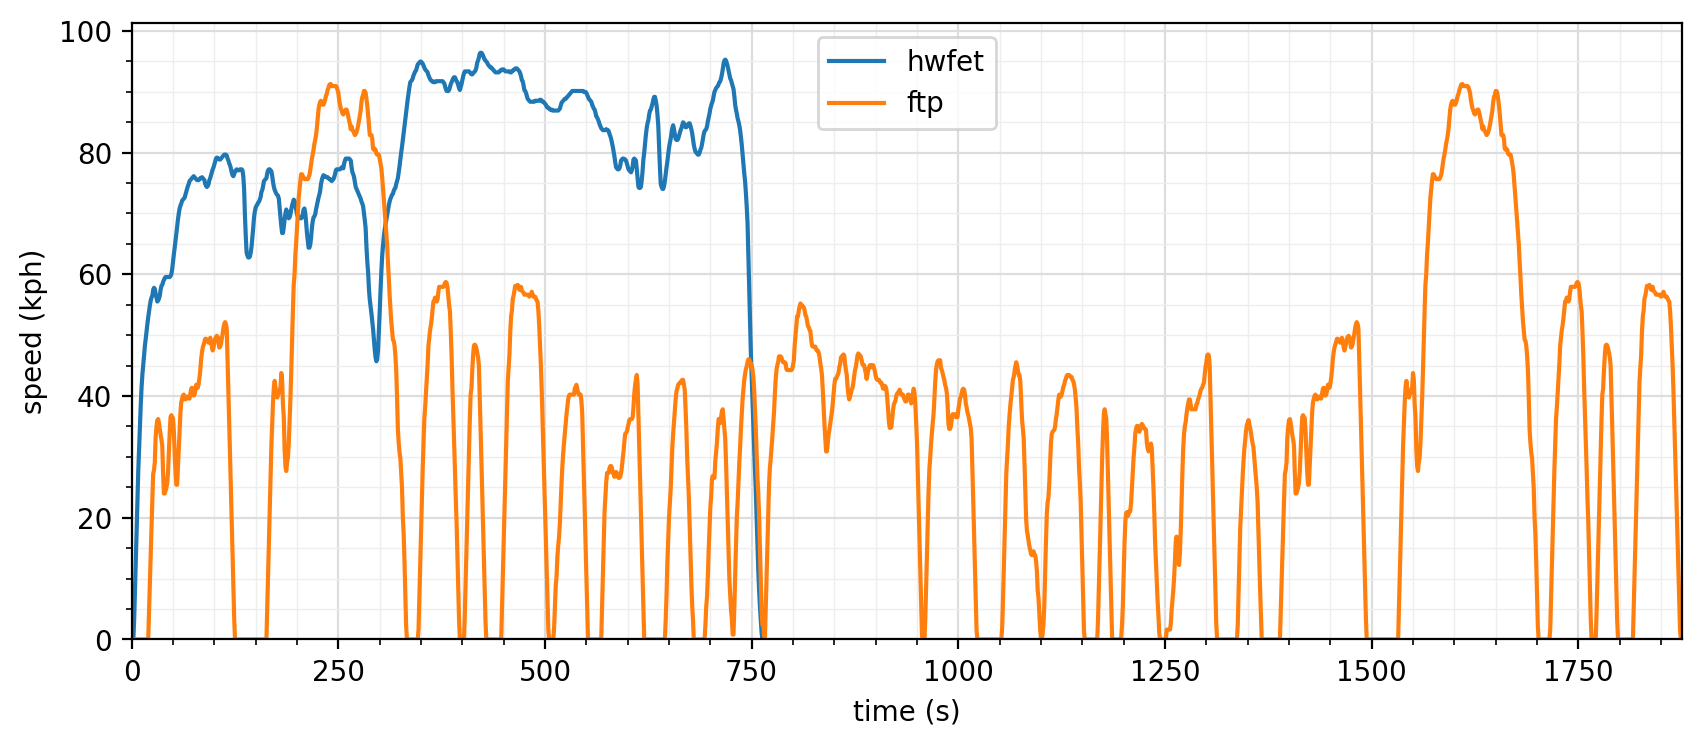

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import hw_utils
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

hwfet_schedule = pd.read_csv("./hw2_hwfet.csv", usecols=[0, 1])
ftp_schedule = pd.read_csv("./hw2_ftp.csv", usecols=[0, 1])

hwfet_schedule.head()
plt.figure(figsize=(10,4))
plt.plot(hwfet_schedule["speed (kph)"], label="hwfet")
plt.plot(ftp_schedule["speed (kph)"], label="ftp")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("speed (kph)")
plt.xlim(0, 1875)
plt.ylim(0)
result = hw_utils.nice_grid(plt)

print(result)

Let's do a sanity check that our distances traveled for these driving schedules are the same as what is given on epa.gov.

(0.0, 1875.0)

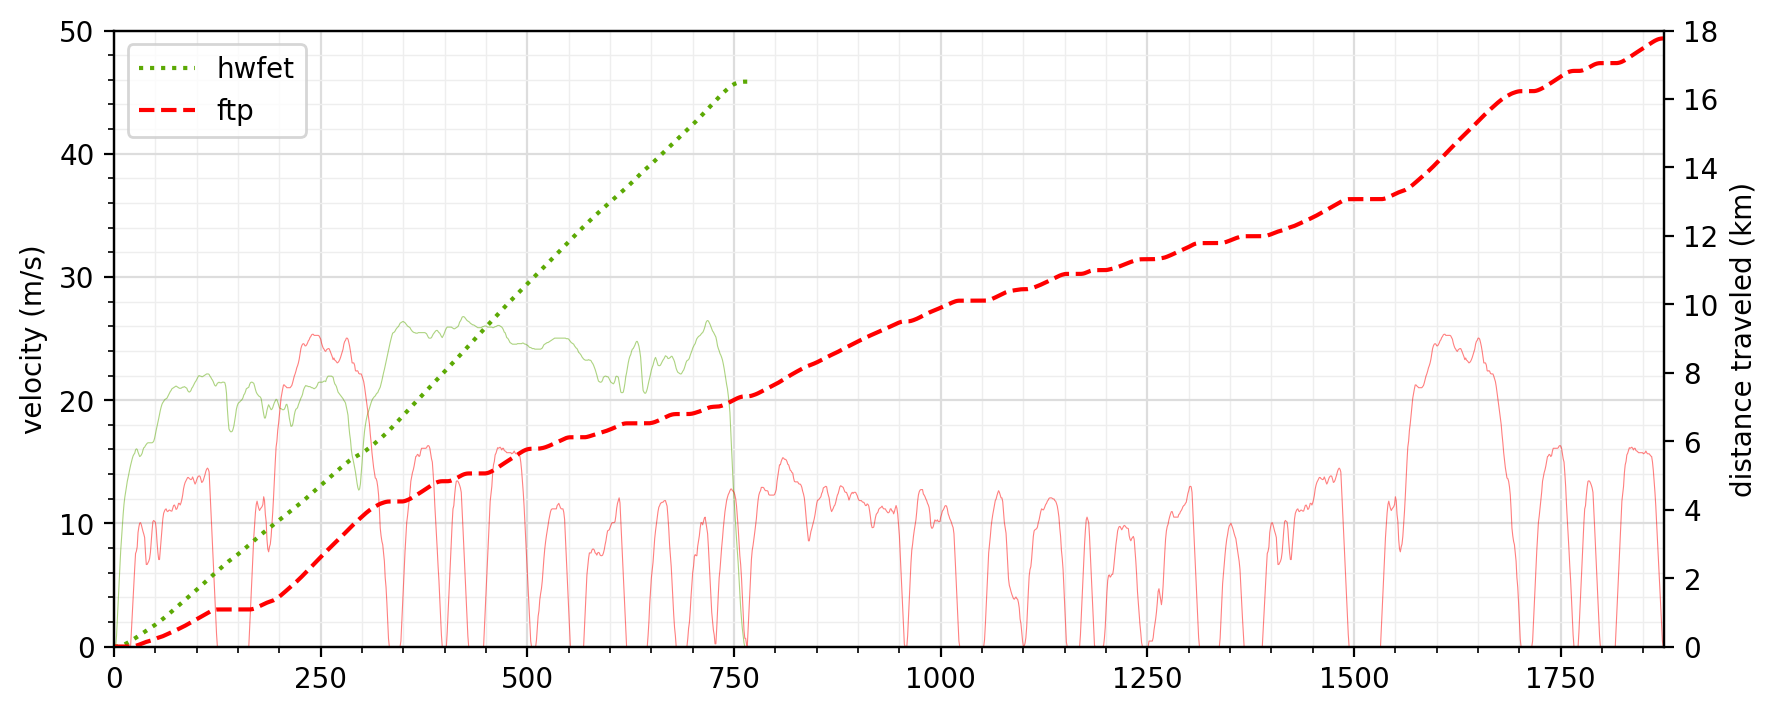

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib

kph_to_mps = 0.277778  # 1 kph = 0.277778 m/s

cycle = dict(
    time=[hwfet_schedule["time"].values, ftp_schedule["time"].values],
    mps=[
        hwfet_schedule["speed (kph)"] * kph_to_mps,
        ftp_schedule["speed (kph)"] * kph_to_mps,
    ],
    name=["hwfet", "ftp"],
)

hwfet_integral = np.array([0, *np.cumsum(cycle["mps"][0])]) / 1000.0
ftp_integral = np.array([0, *np.cumsum(cycle["mps"][1])]) / 1000.0


fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()


ax1.plot(cycle["mps"][0], color="xkcd:leaf green", alpha=0.5, linewidth=0.4)
ax1.plot(cycle["mps"][1], color="red", alpha=0.5, linewidth=0.4)
ax2.plot(hwfet_integral, linestyle="dotted", color="xkcd:leaf green", label="hwfet")
ax2.plot(ftp_integral, linestyle="dashed", color="red", label="ftp")
ax1.set_ylabel("velocity (m/s)")
hw_utils.nice_grid(ax1)


plt.legend()
ax2.set_ylabel("distance traveled (km)")
ax1.set_ylim(0, 50)
ax2.set_ylim(0, 18)
ax1.set_xlim(0, 1875)

Below you will see the road load equation with  instantaneous η<sub>tr</sub> now being considered in the calculation.

In [12]:
#  instantaneous powertrain efficiency with wdot_veh in kW
def instantaneous_eta_tr(wdot_veh):
    a = 0.4
    wdot_1 = 210
    wdot_2 = 18

    return a * ((np.exp(-wdot_veh / wdot_1)) - np.exp(-wdot_veh / wdot_2))


etas_0 = []
t_0 = []
etas_1 = []
t_1 = []


# Function to solve system of 1st-order linear ODEs with oscillatory forcing
def dydt_vehicle(t, y, cycle, vehicle, amb, index, idx):
    global etas_0, etas_1, t_0, t_1
    # Determine instantaneous values of velocity, acceleration, and road angle.
    dydt = [0] * len(y)

    v_veh = np.interp(t, cycle["time"][idx], cycle["v_veh"])
    dv_vehdt = np.interp(t, cycle["time"][idx], cycle["dv_vehdt"])
    alpha = np.pi / 180 * np.interp(t, cycle["time"][idx], cycle["alpha"])

    # Set instantaneous velocity
    dydt[index["x"]] = v_veh

    # Determine instantaneous vehicle load (power demand for engine)
    if v_veh > 0:
        C_roll = vehicle["C_roll_0"] + 1 / vehicle["p_tire"] * (
            0.01 + 9.5e-7 * v_veh**2
        )
        Wdot_veh = (
            vehicle["mass"]
            * (max(0, dv_vehdt + G * np.sin(alpha)) + C_roll * G * np.cos(alpha))
            + vehicle["C_drag"]
            * vehicle["A_front"]
            * 0.5
            * amb["rho"]
            * (v_veh - amb["v_air"]) ** 2
        ) * v_veh + vehicle["Wdot_access"] / vehicle["eta_elec"]
    else:
        Wdot_veh = vehicle["Wdot_access"] / vehicle["eta_elec"]

    dydt[index["E_veh"]] = Wdot_veh

    # Determine power train efficiency and instantaneous fuel energy demand rate
    eta = instantaneous_eta_tr(Wdot_veh / 1000)
    if idx == 0:
        etas_0 = etas_0 + [eta]
        t_0 = t_0 + [t]
    elif idx == 1:
        etas_1 = etas_1 + [eta]
        t_1 = t_1 + [t]

    dydt[index["E_fuel"]] = Wdot_veh / eta
    return dydt


# Set up indices and intial conditions for solution vector y(t) = [x; Wdot_veh]'
index = dict(x=0, E_veh=1, E_fuel=2)
y_0 = [None] * 3
y_0[index["x"]] = 0
y_0[index["E_veh"]] = 0
y_0[index["E_fuel"]] = 0

for idx, speed in enumerate(cycle["mps"]):
    arr_length = len(speed)
    time = cycle["time"][idx]

    #  driving cycle vehicle velocities [m/s]
    cycle["v_veh"] = speed
    # road angle to horizontal  [deg.]
    cycle["alpha"] = [0] * arr_length
    # Calculate vehicle acceleration and identify times when acceleration is positive
    cycle["dv_vehdt"] = np.gradient(cycle["v_veh"])

    # Call an ODE integrator to solve for y(t)
    sol = solve_ivp(
        dydt_vehicle,
        [0, time[-1] + 1],
        y_0,
        "RK45",
        time,
        args=(cycle, vehicle, ambient, index, idx),
        rtol=1e-4,
        atol=1e-4,
    )

    vehicle["x"][idx] = sol.y[index["x"]] / 1000
    vehicle["E_veh"][idx] = sol.y[index["E_veh"]] / 1000
    vehicle["E_fuel"][idx] = sol.y[index["E_fuel"]] / 1000

    # vehicle["kJperkm"][idx] = (
    #     vehicle["kJperkm"][idx] if "kJperkm" in vehicle else [0] * len(cycle["mps"][idx])
    # )
    vehicle["kmperliter"][idx] = [0] * len(cycle["mps"][idx])
    # vehicle["mpg"] = (
    #     vehicle["mpg"] if "mpg" in vehicle else [0] * len(cycle["mps"][idx])
    # )

    # vehicle["kJperkm"][idx] = (
    #     vehicle["E_fuel"][-1] / vehicle["x"][-1]
    # )  # MJ of fuel energy demand per km

    vehicle["kmperliter"][idx] = (
        1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)
    )
    vehicle["mpg"][idx] = 2.35215 * vehicle["kmperliter"][idx]

    #  Allocate memory for vectors for calculating vehicle power requirements
    vehicle["Wdot_drag"][idx] = np.zeros(arr_length)
    vehicle["Wdot_roll"][idx] = np.zeros(arr_length)
    vehicle["Wdot_accel"][idx] = np.zeros(arr_length)

    # Calculate instantaneous power (in kW) to overcome forces on vehicle
    #   and integrate to get total work required (in kWh)
    vehicle["Wdot_drag"][idx] = (
        (
            np.array(
                vehicle["C_drag"]
                * vehicle["A_front"]
                * 0.5
                * ambient["rho"]
                * (np.array(cycle["v_veh"]) - ambient["v_air"]) ** 2
            )
        )
        * cycle["v_veh"]
        / 1000
    )

    C_roll = vehicle["C_roll_0"] + (
        1 / vehicle["p_tire"] * (0.01 + 9.5e-7 * np.array(cycle["v_veh"]) ** 2)
    )
    vehicle["Wdot_roll"][idx] = (
        vehicle["mass"] * C_roll * (G * np.cos(cycle["alpha"]) * cycle["v_veh"] / 1000)
    )
    vehicle["Wdot_accel"][idx] = (
        np.maximum(0, vehicle["mass"] * cycle["dv_vehdt"]) * cycle["v_veh"] / 1000
    )
    vehicle["Wdot_access_vec"][idx] = (
        np.ones(len(speed)) * vehicle["Wdot_access"] / vehicle["eta_elec"] / 1000
    )
    vehicle["Wdot"][idx] = (
        vehicle["Wdot_drag"][idx]
        + vehicle["Wdot_roll"][idx]
        + vehicle["Wdot_accel"][idx]
        + vehicle["Wdot_access_vec"][idx]
    )

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_98276/954799722.py:108: RuntimeWarning: invalid value encountered in divide
  1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)


Let's plot the drivetrain efficiency throughout both cycles to make sure we are seeing reasonable values.

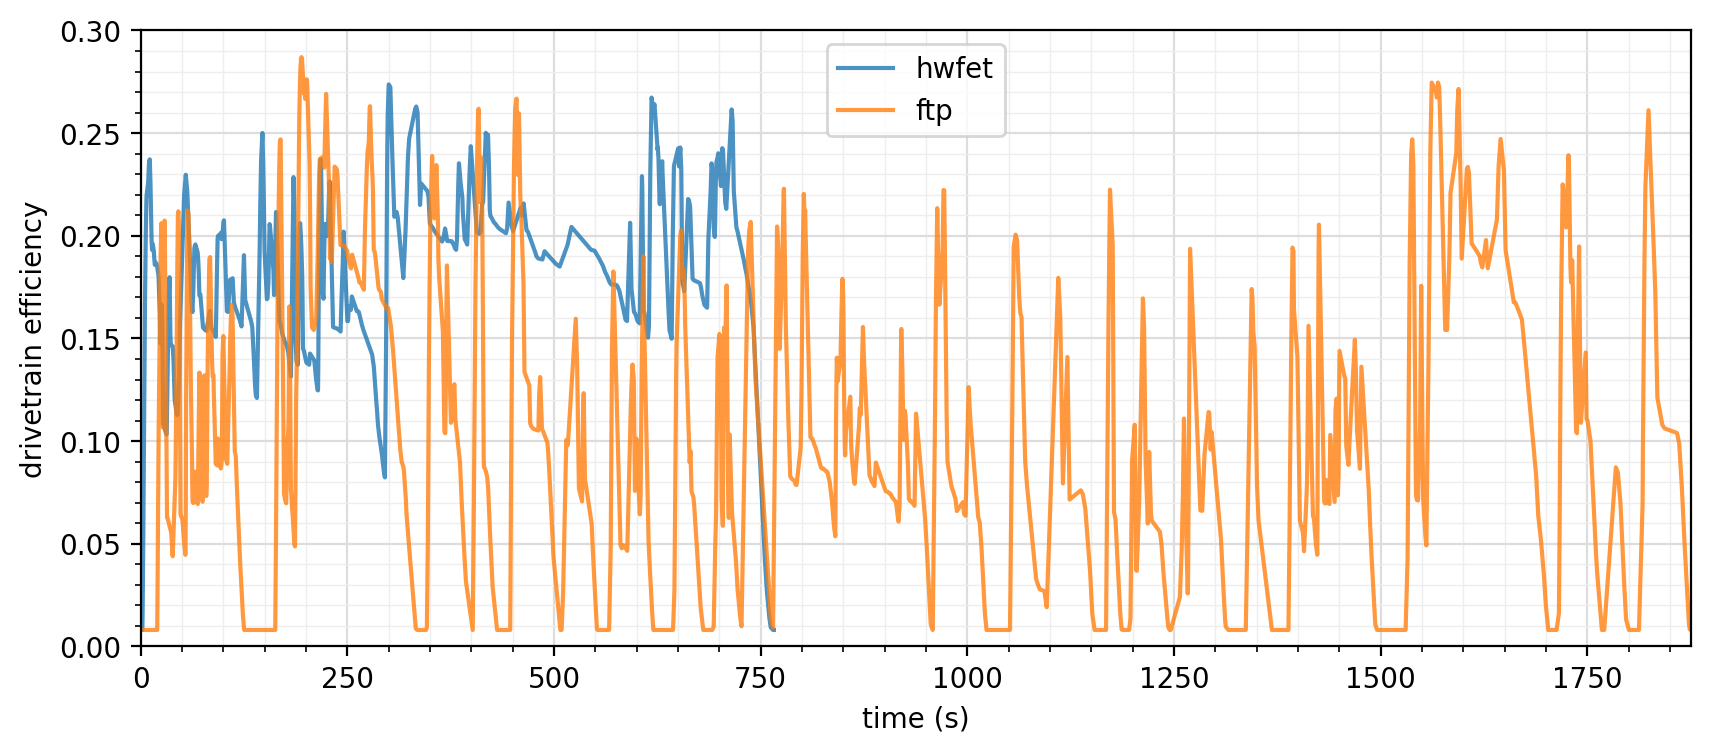

In [13]:
indices = np.argsort(t_0)
t_0 = np.array(t_0)[indices]
etas_0 = np.array(etas_0)[indices]

indices = np.argsort(t_1)
t_1 = np.array(t_1)[indices]
etas_1 = np.array(etas_1)[indices]

plt.figure(figsize=(10,4))
plt.plot(t_0, etas_0, label=cycle["name"][0], alpha=0.8)
plt.plot(t_1, etas_1, label=cycle["name"][1], alpha=0.8)
plt.ylim(0, 0.3)
plt.xlim(0, 1875)
plt.xlabel("time (s)")
plt.ylabel("drivetrain efficiency")
plt.legend()
hw_utils.nice_grid(plt)

Ok, with max drivetrain efficiency looking like about 0.28, things are looking good.

Let's now make the plots that are actually asked for in problem 1a.
### First, Instantaneous Vehicle Loads

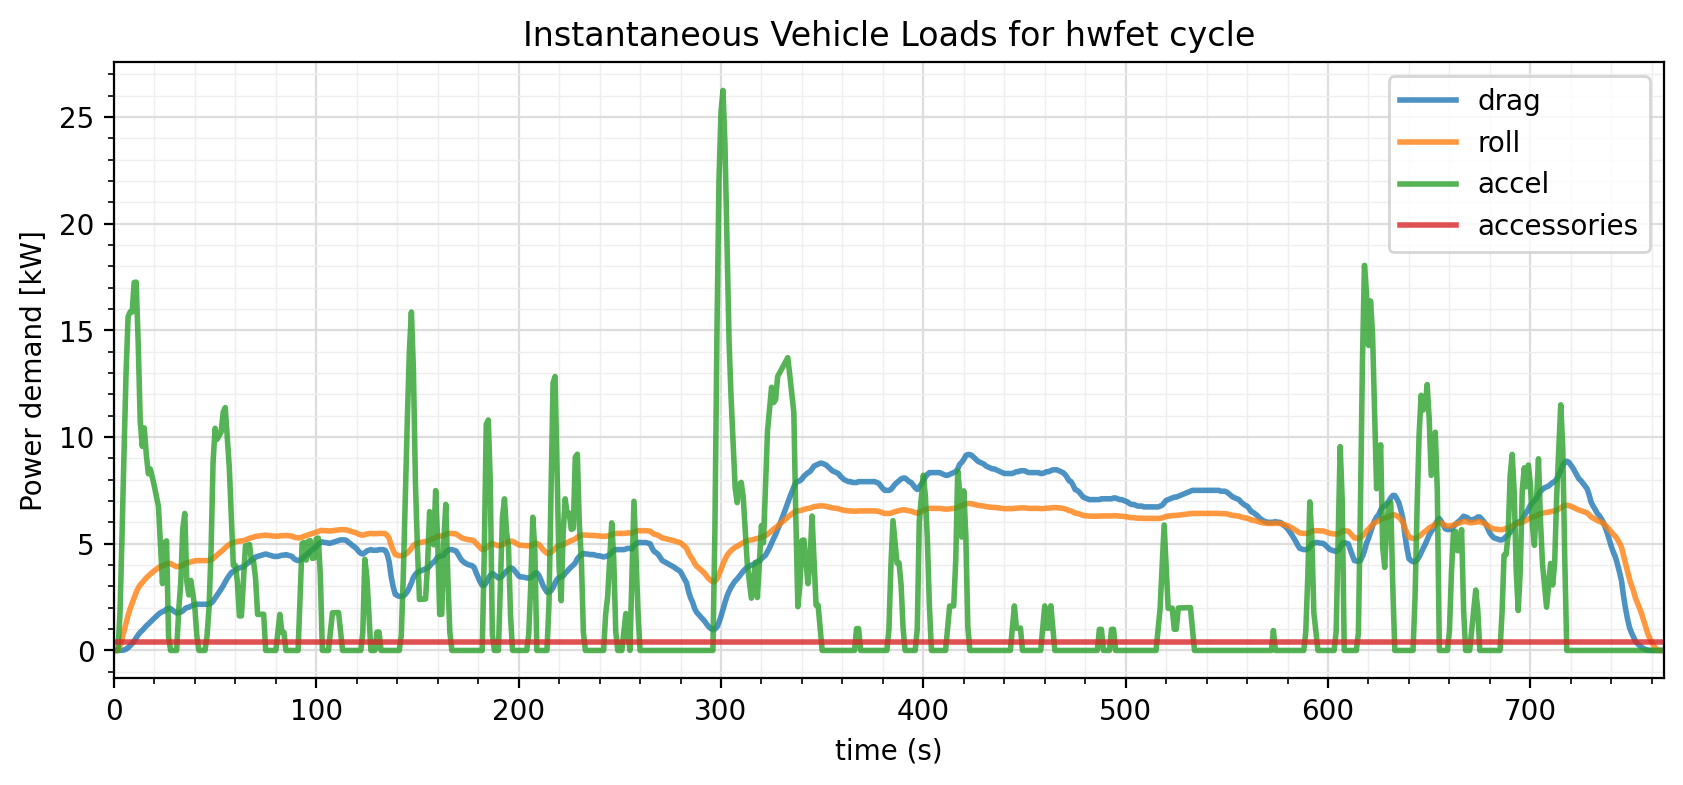

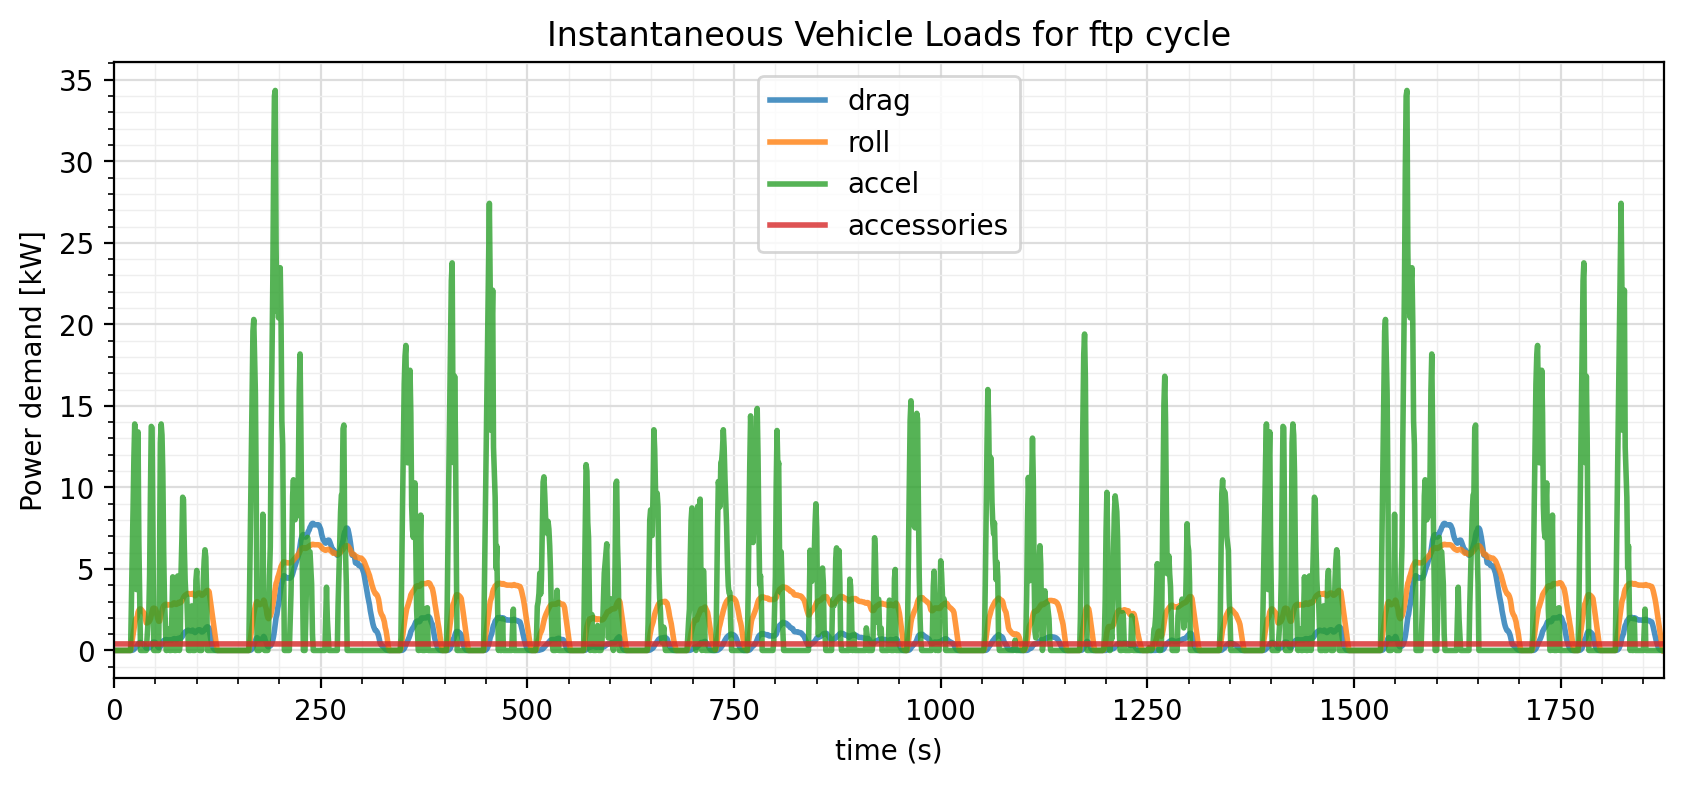

In [14]:
# Plot instantaneous power required for each load for each cycle
for i in [0, 1]:
    plt.figure(figsize=(10, 4))
    plt.plot(
        cycle["time"][i], vehicle["Wdot_drag"][i], label="drag", linewidth=2, alpha=0.8
    )
    plt.plot(
        cycle["time"][i], vehicle["Wdot_roll"][i], label="roll", linewidth=2, alpha=0.8
    )
    plt.plot(
        cycle["time"][i],
        vehicle["Wdot_accel"][i],
        label="accel",
        linewidth=2,
        alpha=0.8,
    )
    plt.plot(
        cycle["time"][i],
        vehicle["Wdot_access_vec"][i],
        label="accessories",
        linewidth=2,
        alpha=0.8,
    )
    plt.xlabel("time (s)")
    plt.ylabel("Power demand [kW]")
    hw_utils.nice_grid(plt)
    plt.xlim(0, len(cycle["time"][i]))
    plt.legend()
    plt.title(f'Instantaneous Vehicle Loads for {cycle["name"][i]} cycle')

### Second, Integrated Load

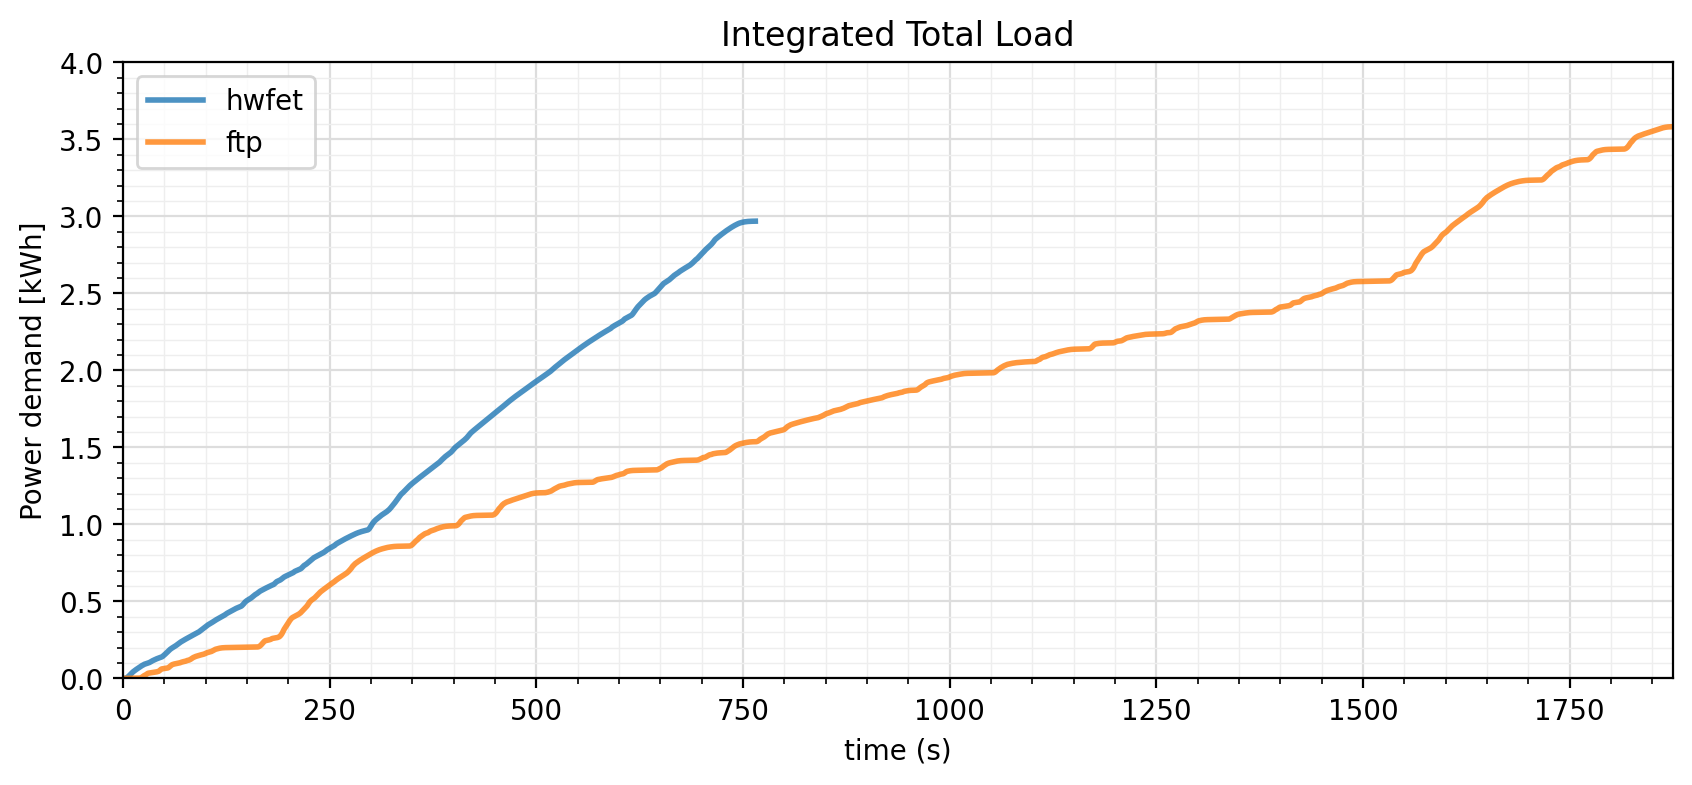

In [15]:
plt.figure(figsize=(10, 4))
for i in [0, 1]:
    plt.plot(
        cycle["time"][i],
        np.cumsum(vehicle["Wdot"][i]) / 3600,
        label=cycle["name"][i],
        linewidth=2,
        alpha=0.8,
    )
    plt.xlabel("time (s)")
    plt.ylabel("Power demand [kWh]")
    hw_utils.nice_grid(plt)
    plt.xlim(0, len(cycle["time"][i]))
    plt.ylim(0, 4)
    plt.legend()
    plt.title("Integrated Total Load")

### Third, fuel economy


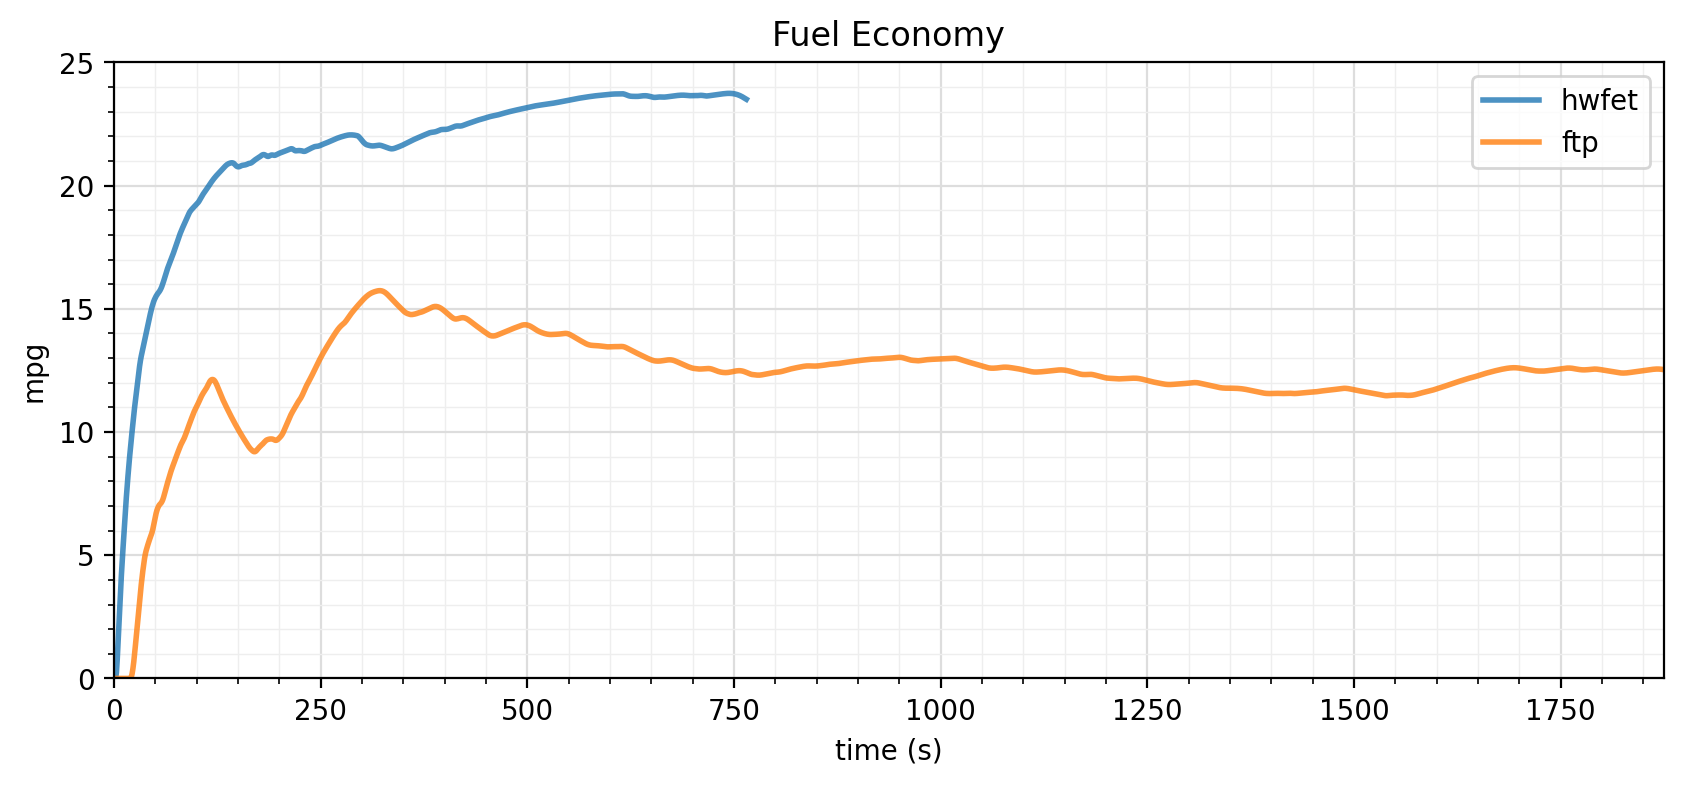

In [21]:
plt.figure(figsize=(10, 4))
for i in [0, 1]:
    plt.plot(
        cycle["time"][i],
        vehicle["mpg"][i],
        label=cycle["name"][i],
        linewidth=2,
        alpha=0.8,
    )
    plt.xlabel("time (s)")
    plt.ylabel("mpg")
    hw_utils.nice_grid(plt)
    plt.xlim(0, len(cycle["time"][i]))
    plt.ylim(0, 25)
    plt.legend()
    plt.title("Fuel Economy")

In [ ]:

# Plot average power demand for each force or load
categories = ["drag", "roll", "accel", "accessories"]
num_categories = len(categories)
num_values = len(vehicle["Wdot_drag_avg"])  # Assuming all lists have the same length

# Setting up the bar width and positions
bar_width = 0.2
# Create an array for the positions of groups
index = np.arange(num_categories)

fig, ax = plt.subplots()

labels = [""]
for i in range(num_values):
    # Creating the bars for each category
    ax.bar(
        index - bar_width / 2 + i * bar_width,
        [
            vehicle["Wdot_drag_avg"][i],
            vehicle["Wdot_roll_avg"][i],
            vehicle["Wdot_accel_avg"][i],
            vehicle["Wdot_access_vec_avg"][i],
        ],
        bar_width,
        label=f"cycle {i + 1}",
    )

# Additional chart settings
ax.set_ylabel("Average Power demand over cycle (kW)")
ax.set_title(f"Average Power Demand")
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

print("average power", vehicle["Wdot_avg"])
print("kjperkm", vehicle["kJperkm"])
print("work done during cycle in kJ", vehicle["work"])
plt.figure()
plt.scatter(["cycle 1", "cycle 2"], vehicle["work"][0:2])
plt.ylim(0, 90)
plt.ylabel("average km/liter")
hw_utils.nice_grid(plt)


# %%
# Plot averge fuel economy for vehicle
# plt.plot(cycle["kph"], vehicle["kmperliter"], linewidth=2)
# plt.xlabel("Vehicle speed [kph]")
# plt.ylabel("km/liter")
# plt.title(f'Average Fuel Economy for {cycle["name"]}')
# plt.xlim(60, 120)